# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

Энтропийная функция:

$\psi(x) = \sum \limits_1^d x_i \log x_i$.

Тогда выражение для дивергенции Брегмана имеет вид:

$V(x, y) = \sum \limits_1^d x_i \log x_i - \sum \limits_1^d y_i \log y_i - \sum \limits_1^d (\log x_i + 1)(x_i - y_i) = \sum \limits_1^d x_i \log \dfrac{x_i}{y_i}$.

Итерация метода зеркального спуска:

$x^{k+1} = \arg \underset{x \in C}{\min} \left(\gamma \langle\nabla f(x^k), x\rangle + V(x, x^k) \right) = \arg \underset{x \in \triangle_d}{\min} \left(\gamma \langle\nabla f(x^k), x\rangle + \sum \limits_1^d x_i \log \dfrac{x_i}{x^k_i}\right).$

$\nabla f(x) = \dfrac{A + A^T}{2}x = Ax,$ если $A$ - симметричная.

Тогда шаг метода можем записать следующим образом:

$x^{k+1} = \dfrac{\sum \limits_1^d x_i^k \exp(-\gamma(Ax^k)_i) \cdot e_i}{\sum \limits_1^d x_i^k \exp(-\gamma(Ax^k)_i)},$ где $\{e_i\}_i^d$ $-$ базис в $\mathbb{R}^d$.

In [2]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt

from numba import jit
import warnings
warnings.filterwarnings("ignore")

def generate(d = 3, m = 1, L = 5):

    if d == 1 and m == L:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]
        
    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    return A

@jit
def f(x):
    return 0.5 * x.T @ A @ x

@jit
def step(x, gamma):
    y = [x[i] * math.exp(-gamma * (A @ x)[i]) for i in range(d)]
    return y/sum(y)

In [3]:
L = 1000
mu = 1
d = 20

A = generate(d, mu, L)

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Перепишем выражение для критерия:

$ \text{gap}(x^k) = \underset{y \in \triangle_d}{\max} (x^k - y)^T Ax,$ введем вектор $c: c_i = a_i^Tx^k$, где $a_i - i$-ая строка матрицы $A$. Получаем:

$$(x^k - y)^Tc \rightarrow \max, \; y \in \triangle_d.$$ 

Т.о., мы получили задачу линейного программирования с бюджетным множеством в виде симплекса. Как известно, решение такой задачи находится на его вершинах:

$$ \text{gap}(x^k) = \underset{i \in \overline{1, d}}{\max} \left( (x_i^k - 1) \cdot a_i^Tx^k \right).$$

$\max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle =
​​​​​​​\langle \nabla f(x^k), x^k \rangle
+\max_{y \in \triangle_d} \langle \nabla f(x^k), - y \rangle$

In [4]:
def gap(x):
    ans = 0
    for i in range(d):
        gap_i = abs((x[i] - 1) * A[i].T @ x)
        if gap_i > ans:
            ans = gap_i
    return ans

In [5]:
def mirror_descent(gamma=0.001, iters=2000):

    x = np.random.uniform(low=0, high=1, size=(d,))
    x_vals = [x]
    f_vals = [f(x)]

    for i in range(iters):
        x = step(x, gamma=gamma)
        x_vals.append(x)
        f_vals.append(f(x))

    return x_vals, f_vals

In [6]:
iters=2000
x_md, f_md = mirror_descent(iters=iters)
print(f_md[-1])
print(sum(x_md[-1]))

5.684978203028364
1.0


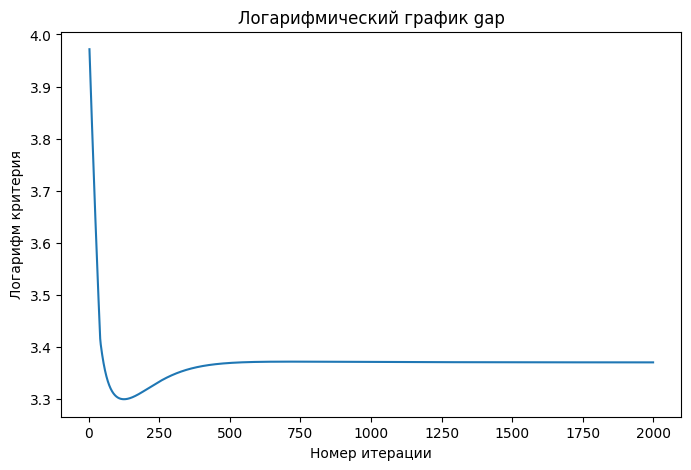

In [25]:
x = range(3, iters)
y = [gap(x_md[k]) for k in x]

plt.figure(figsize=(8, 5))
plt.plot(x, np.log(y))
plt.xlabel("Номер итерации")
plt.ylabel("Логарифм критерия")
plt.title('Логарифмический график gap')
plt.show()

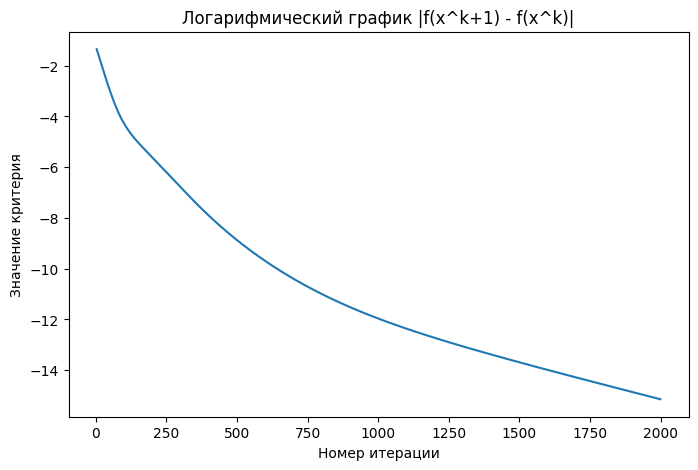

In [26]:
# смутило, что gap сходится не к нулю
# посмотрим на какой-нибудь старый критерий и убедимся, что все ок
# критерий |f(x^k+1) - f(x^k)|

x = range(3, iters)
y = [abs(f(x_md[k]) - f(x_md[k-1])) for k in x]

plt.figure(figsize=(8, 5))
plt.plot(x, np.log(y))
plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.title('Логарифмический график |f(x^k+1) - f(x^k)|')
plt.show()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

Итерация метода:

$$ s^k = \arg \underset{s \in C}{\min} \langle \nabla f(x^k), s - x^k \rangle $$

$$ x^{k+1} = x^k + \gamma^k (s^k - x^k) $$

Поиск $s^k$ сводится к решению задачи $\langle Ax, s-x \rangle \rightarrow \min$.

Поскольку $0 \notin \triangle_d$, минимум функции $\langle \nabla f(x), s - x \rangle$ достигается на одной из вершин симплекса. История та же, что и при вычислении gap.

In [9]:
def s(x):
    gap = abs((x[0] - 1) * A[0].T @ x)
    k = 0
    for i in range(1, d):
        gap_i = abs((x[i] - 1) * A[i].T @ x)
        if gap_i < gap:
            k = i
    v = np.zeros(d)
    v[k] = 1
    return v

def frank_wolfe(iters=2000):

    x = np.random.uniform(low=0, high=1, size=(d,))
    x_vals = [x]
    f_vals = [f(x)]

    # берем gamma убывающую с номером итерации
    for i in range(iters):
        x = x + 2 / (2*i+10) * (s(x) - x)
        x_vals.append(x)
        f_vals.append(f(x))

    return x_vals, f_vals

In [10]:
iters = 2000
x_fw, f_fw = frank_wolfe(iters=iters)
print(f_fw[-1])
print(sum(x_fw[-1]))

6.85429828863867
1.019754485740862


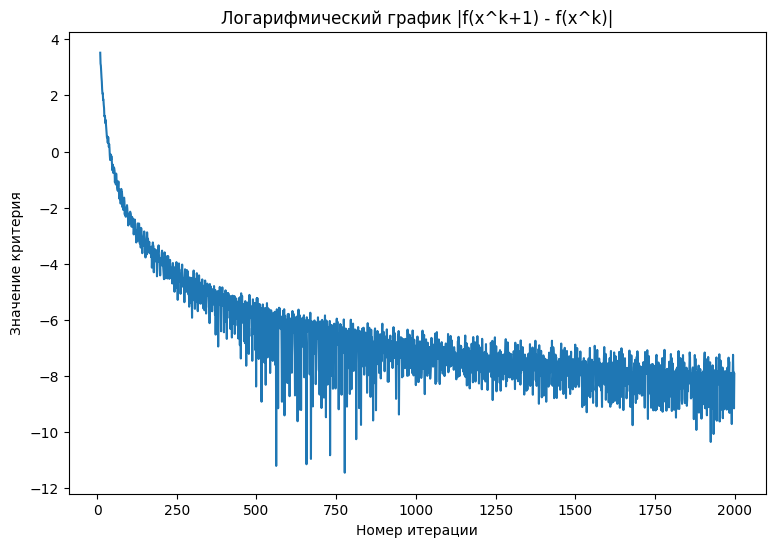

In [20]:
x = range(10, iters)
y = [abs(f(x_fw[k]) - f(x_fw[k-1])) for k in x]

plt.figure(figsize=(9, 6))
plt.plot(x, np.log(y))
plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.title('Логарифмический график |f(x^k+1) - f(x^k)|')
plt.show()

Из-за того, что значение $s^k$ меняется дискретно, график сходимости выглядит весьма забористо. Тем не менее, огибающая графика монотонно убывает, то есть метод действительно сходится. Сравним его с зеркальным спуском.

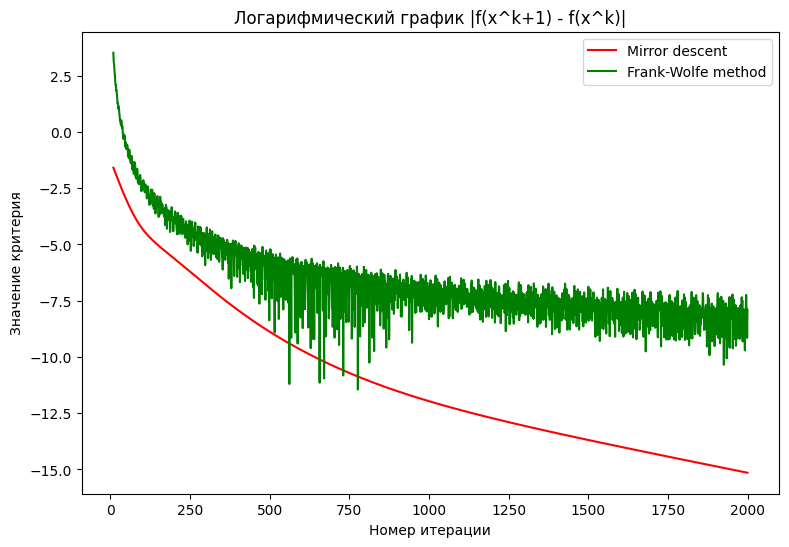

In [27]:
x = range(10, iters)
y1 = [abs(f(x_md[k]) - f(x_md[k-1])) for k in x]
y2 = [abs(f(x_fw[k]) - f(x_fw[k-1])) for k in x]

plt.figure(figsize=(9, 6))
plt.plot(x, np.log(y1), color='red', label='Mirror descent')
plt.plot(x, np.log(y2), color='green', label='Frank-Wolfe method')

plt.xlabel("Номер итерации")
plt.ylabel("Значение критерия")
plt.title('Логарифмический график |f(x^k+1) - f(x^k)|')
plt.legend(fontsize=10)
plt.show()

Видим, что скорость сходимости метода зеркального спуска значительно превосходит метод Франка-Вульфа.

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [12]:
#ответ

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [13]:
#ответ